Imports

In [2]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import os
import pickle

import importlib
import src
from src.dataset import info, check
importlib.reload(src)

X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data(one_speed=True, all_features=True)
# check(X_train, "np", (1280004, 6)) # For all speeds
# check(y_train, "np", (1280004, 3))
# check(X_train, "np", (256000, 6)) # For one speed
# check(y_train, "np", (256000, 3))
# check(X_test, "np", (320001, 6))
# check(y_test, "np", (320001, 3))
# check(X_test, "np", (64001, 6))
# check(y_test, "np", (64001, 3))

check(X_train, "np", (256000, 18)) # For one speed, all features
check(y_train, "np", (256000, 3))
check(X_test, "np", (64001, 18))
check(y_test, "np", (64001, 3))

print(X_train)

Python random seed set.
NumPy random seed set.
PyTorch random seed set.
Python random seed set.
NumPy random seed set.
PyTorch random seed set.
Loaded from pickle
[[1.40867410e-01 5.40330113e-01 6.81486694e-01 ... 6.83530409e-01
  0.00000000e+00 6.65917693e-01]
 [1.00981329e-01 5.42141986e-01 6.81373323e-01 ... 6.83359663e-01
  3.12500000e-06 6.31657932e-01]
 [1.42259072e-01 5.42073273e-01 6.82784879e-01 ... 6.84681683e-01
  6.25000000e-06 6.37550275e-01]
 ...
 [6.17626361e-01 4.24799873e-01 8.28272883e-01 ... 8.28540968e-01
  7.99990625e-01 3.58636254e-01]
 [6.11630421e-01 4.24010040e-01 8.27337437e-01 ... 8.27672758e-01
  7.99993750e-01 3.62249315e-01]
 [6.33986624e-01 4.25800418e-01 8.29139550e-01 ... 8.29529980e-01
  7.99996875e-01 3.73192123e-01]]


Model setup

In [3]:
class RBFNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(RBFNN, self).__init__()
        
        # Define layers
        self.layers = nn.ModuleList()
        prev_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.layers.append(nn.ReLU())  # Add activation function
            prev_size = hidden_size
        
        # Add output layer
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        # Apply each hidden layer
        for layer in self.layers:
            x = layer(x)

        # Apply output layer
        x = self.output_layer(x)
        return x


In [4]:
model = RBFNN(len(X_train[0]), [64, 128, 128, 64], 1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [5]:
# Example training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients

    outputs = model(torch.from_numpy(X_train).float())  # Forward pass
    loss = criterion(outputs, torch.from_numpy(y_train[:, 0].reshape(-1, 1)).float())  # Compute loss

    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.06801611185073853
Epoch 2/500, Loss: 0.012091642245650291
Epoch 3/500, Loss: 0.16954216361045837
Epoch 4/500, Loss: 0.013385606929659843
Epoch 5/500, Loss: 0.01868555136024952
Epoch 6/500, Loss: 0.02789069339632988
Epoch 7/500, Loss: 0.031853970140218735
Epoch 8/500, Loss: 0.03306928649544716
Epoch 9/500, Loss: 0.032657645642757416
Epoch 10/500, Loss: 0.0312529131770134
Epoch 11/500, Loss: 0.0292171910405159
Epoch 12/500, Loss: 0.02680000104010105
Epoch 13/500, Loss: 0.024158518761396408
Epoch 14/500, Loss: 0.0213619451969862
Epoch 15/500, Loss: 0.018556443974375725
Epoch 16/500, Loss: 0.01565123163163662
Epoch 17/500, Loss: 0.013297097757458687
Epoch 18/500, Loss: 0.012590144760906696
Epoch 19/500, Loss: 0.014041918329894543
Epoch 20/500, Loss: 0.01451666746288538
Epoch 21/500, Loss: 0.013674411922693253
Epoch 22/500, Loss: 0.01263296790421009
Epoch 23/500, Loss: 0.012097536586225033
Epoch 24/500, Loss: 0.012096870690584183
Epoch 25/500, Loss: 0.012312284670770168

-----
-----
Mean Squared Error: 0.000999030889943242


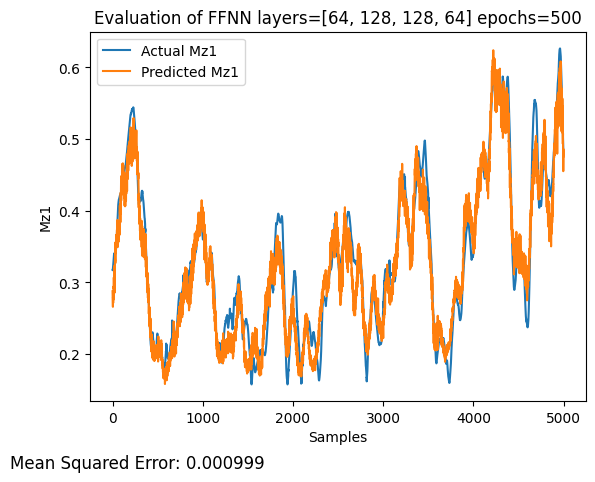

In [6]:
y_pred = model.forward(torch.from_numpy(X_test).float())
info(y_pred)

# Print the loss
print("Mean Squared Error:", loss.item())

start = 10000
src.plots.evaluate_predictions(y_pred.detach().numpy()[start:start+5000], y_test[:, 0][start:start+5000], loss.item(), name=f"FFNN layers=[64, 128, 128, 64] epochs={epochs}")